In [1]:
%matplotlib inline

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
# Load Airbnb data
airbnb = pd.read_csv("./data/airbnb-listings-extract.csv", sep=";", header=0)
airbnb.shape

(14780, 89)

In [5]:
# Filter Madrid samples
madrid_filter = [True if "madrid" in street.lower() and country == "Spain" else False
     for street, country in zip(airbnb["Street"], airbnb["Country"])]
madrid = airbnb[madrid_filter]
madrid.shape

(13268, 89)

In [69]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
mad_train, mad_test = train_test_split(madrid, test_size=.25, random_state=0, shuffle=True)

print(f"Train dimension: {mad_train.shape}")
print(f"Test dimension: {mad_test.shape}")

Train dimension: (9951, 89)
Test dimension: (3317, 89)


## 1. Exploratory Analysis & Preprocessing

In [70]:
mad_train.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
5209,11132701,https://www.airbnb.com/rooms/11132701,20170407214119,2017-04-08,Sitio tranquilo en centro de Madrid,Nos gusta viajar por lo que tenemos muchos det...,El alojamiento consiste en una bonita y lumino...,Nos gusta viajar por lo que tenemos muchos det...,none,Se trata de un barrio muy típico de Madrid lle...,NaN,Si vienes en coche y no estás dispuesto a paga...,Si vienes en pareja podemos gestionar una cama...,NaN,NaN,https://a0.muscache.com/im/pictures/07d7627a-9...,https://a0.muscache.com/im/pictures/07d7627a-9...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/07d7627a-9...,57852833,https://www.airbnb.com/users/show/57852833,Alvaro,2016-02-08,"Madrid, Community of Madrid, Spain",Soy una persona inquieta que he vivido en vari...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/41564943-d...,https://a0.muscache.com/im/pictures/41564943-d...,Arapiles,1.0,1.0,"email,phone,reviews,jumio,government_id","Arapiles, Madrid, Comunidad de Madrid 28015, S...",Arapiles,Arapiles,Chamberí,Madrid,Comunidad de Madrid,28015,Madrid,"Madrid, Spain",ES,Spain,40.435621,-3.705200,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"Wireless Internet,Air conditioning,Kitchen,Ele...",NaN,20.0,100.0,NaN,NaN,NaN,1,0,1,1125,6 months ago,NaN,0,0,0,0,2017-04-08,2,2016-04-15,2016-04-17,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,flexible,1.0,0.17,"40.4356210173,-3.70519989444","Host Has Profile Pic,Host Identity Verified,Is..."
9880,2704499,https://www.airbnb.com/rooms/2704499,20170407214119,2017-04-08,"Apartment Lavapies, Center Madrid","Enjoy our apartment, completely new and equipp...",Un corridoio che noi usiamo come libreria vi p...,"Enjoy our apartment, completely new and equipp...",none,The neighborhood of Lavapiés is one of the mos...,NaN,"If you like to walk, pleasantly roaming you’ll...",La casa sarà completamente a disposizione dei ...,Ci incontreremo con voi durante il check-in e ...,"Ci farà piacere che gli ospiti vivano ""piename...",NaN,NaN,https://public.opendatasoft.com/api/v2/catalog...,NaN,13841663,https://www.airbnb.com/users/show/13841663,Andrea,2014-04-03,"Madrid, Community of Madrid, Spain","Mi chiamo Andrea, sono un architetto e vivo co...",within a day,100.0,NaN,https://a0.muscache.com/im/users/13841663/prof...,https://a0.muscache.com/im/users/13841663/prof...,Embajadores,2.0,2.0,"email,phone,reviews","Embajadores, Madrid, Community of Madrid 28012...",Embajadores,Embajadores,Centro,Madrid,Community of Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,40.410776,-3.699472,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in build...",NaN,75.0,400.0,NaN,NaN,20.0,2,20,2,14,5 weeks ago,NaN,0,0,0,251,2017-04-08,11,2014-10-06

In [71]:
# Drop columns
columns = [col for col in madrid.columns if "id" in col.lower().split() or "url" in col.lower().split()]
columns += ["Last Scraped", "Name", "Summary", "Space", "Description", "Experiences Offered",
            "Neighborhood Overview", "Notes", "Transit", "Access", "Interaction",
            "House Rules", "Host Name", "Host Since", "Host Location", "Host About",
            "Host Neighbourhood", "Host Listings Count", "Host Total Listings Count",
            "Host Verifications", "Street", "Neighbourhood", "Neighbourhood Group Cleansed",
            "Neighbourhood Cleansed", "City", "State", "Zipcode", "Market", "Smart Location",
            "Country Code", "Country", "Weekly Price", "Monthly Price", "Calendar Updated",
            "Has Availability", "Calendar last Scraped", "First Review", "Last Review",
            "Jurisdiction Names", "Calculated host listings count", "Geolocation",
            "Features"]

mad_train.drop(columns, axis=1, inplace=True)
mad_test.drop(columns, axis=1, inplace=True)

mad_train.insert(0, "Price", mad_train.pop("Price"))
mad_test.insert(0, "Price", mad_test.pop("Price"))

In [72]:
mad_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9951 entries, 5209 to 3237
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9946 non-null   float64
 1   Host Response Time           8721 non-null   object 
 2   Host Response Rate           8721 non-null   float64
 3   Host Acceptance Rate         0 non-null      object 
 4   Latitude                     9951 non-null   float64
 5   Longitude                    9951 non-null   float64
 6   Property Type                9951 non-null   object 
 7   Room Type                    9951 non-null   object 
 8   Accommodates                 9951 non-null   int64  
 9   Bathrooms                    9915 non-null   float64
 10  Bedrooms                     9934 non-null   float64
 11  Beds                         9915 non-null   float64
 12  Bed Type                     9951 non-null   object 
 13  Amenities      

In [73]:
# Categorical and numerical variables
categorical = []
numerical = []
for col, type_ in zip(mad_train.columns, mad_train.dtypes):
  if mad_train[col].notna().sum():
    if type_ == "object":
      categorical.append(col)
    else:
      numerical.append(col)

In [74]:
for x in categorical:
  print(mad_train[x].value_counts(), "\n\n")

within an hour        5339
within a few hours    2024
within a day          1141
a few days or more     217
Name: Host Response Time, dtype: int64 


Apartment             8168
House                  746
Bed & Breakfast        265
Condominium            255
Loft                   225
Other                  167
Dorm                    32
Guesthouse              24
Chalet                  20
Hostel                  11
Serviced apartment       9
Townhouse                8
Boutique hotel           6
Earth House              3
Villa                    3
Camper/RV                2
Guest suite              2
Boat                     1
Timeshare                1
Casa particular          1
Bungalow                 1
Tent                     1
Name: Property Type, dtype: int64 


Entire home/apt    5939
Private room       3856
Shared room         156
Name: Room Type, dtype: int64 


Real Bed         9723
Pull-out Sofa     187
Futon              26
Couch              12
Airbed              3
Name

### 1.1. Statistics

In [75]:
mad_train[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,9946.0,65.644480,56.093365,9.000000,31.000000,52.000000,80.000000,875.000000
Host Response Rate,8721.0,94.661965,15.524956,0.000000,100.000000,100.000000,100.000000,100.000000
Latitude,9951.0,40.420598,0.020167,40.331888,40.410063,40.418662,40.427829,40.562736
Longitude,9951.0,-3.697059,0.023841,-3.863907,-3.707719,-3.701512,-3.693805,-3.531159
Accommodates,9951.0,3.180987,1.995750,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,9915.0,1.254665,0.607886,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,9934.0,1.294041,0.825699,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,9915.0,1.987494,1.537260,1.000000,1.000000,1.000000,2.000000,16.000000
Square Feet,401.0,369.476309,541.353420,0.000000,0.000000,100.000000,624.000000,5167.000000
Security Deposit,4223.0,184.687900,112.125083,70.000000,100.000000,150.000000,200.000000,990.000000


### 1.2. Outliers

In [76]:
# Remove outliers
mad_train = mad_train[mad_train["Bathrooms"] >= 1]
mad_test = mad_test[mad_test["Bathrooms"] >= 1]

### 1.3. Missing values

In [77]:
# Replace missing values in Security Deposit and Cleaning Fee
mad_train["Security Deposit"].fillna(0, inplace=True)
mad_train["Cleaning Fee"].fillna(0, inplace=True)

mad_test["Security Deposit"].fillna(0, inplace=True)
mad_test["Cleaning Fee"].fillna(0, inplace=True)

In [78]:
# Remove missing values
mask = mad_train.isna().sum() / mad_train.shape[0] > .9
mad_train.drop(mad_train.columns[mask], axis=1, inplace=True)
mad_test.drop(mad_test.columns[mask], axis=1, inplace=True)

mad_train.dropna(inplace=True)
mad_test.dropna(inplace=True)

### 1.4. Encoding

In [79]:
from sklearn.preprocessing import OneHotEncoder

# Property-type one-hot encoding
ohe_proptype = OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=.02).fit(mad_train["Property Type"].values.reshape(-1, 1))
ohe_proptype_train = ohe_proptype.transform(mad_train["Property Type"].values.reshape(-1, 1)).toarray()
ohe_proptype_test = ohe_proptype.transform(mad_test["Property Type"].values.reshape(-1, 1)).toarray()

ohe_proptype_cols = ["proptype_apartment",
                     "proptype_b&b",
                     "proptype_condo",
                     "proptype_house",
                     "proptype_loft",
                     "proptype_other"
                     ]

mad_train.loc[:, ohe_proptype_cols] = ohe_proptype_train
mad_test.loc[:, ohe_proptype_cols] = ohe_proptype_test

# Bed-type dummy encoding
mad_train["bedtype_realbed"] = np.where(mad_train["Bed Type"] == "Real Bed", 1, 0)
mad_test["bedtype_realbed"] = np.where(mad_test["Bed Type"] == "Real Bed", 1, 0)

mad_train.drop(["Property Type", "Bed Type"], axis=1, inplace=True)
mad_test.drop(["Property Type", "Bed Type"], axis=1, inplace=True)

In [80]:
from sklearn.preprocessing import LabelEncoder

# Host-Response-Time label encoding:
# "a few days or more", "within a day", "within a few hours", "within an hour"
le_responsetime = LabelEncoder().fit(mad_train["Host Response Time"])
mad_train["Host Response Time"] = le_responsetime.transform(mad_train["Host Response Time"])
mad_test["Host Response Time"] = le_responsetime.transform(mad_test["Host Response Time"])

# Cancellation-Policy label encoding:
# "flexible", "moderate", "strict", "super_strict"
superstrict = ["super_strict_30", "super_strict_60"]
superstrict_train = mad_train["Cancellation Policy"].isin(superstrict)
mad_train.loc[superstrict_train, "Cancellation Policy"] = "super_strict"
superstrict_test = mad_test["Cancellation Policy"].isin(superstrict)
mad_test.loc[superstrict_test, "Cancellation Policy"] = "super_strict"

le_cancelpolicy = LabelEncoder().fit(mad_train["Cancellation Policy"])
mad_train["Cancellation Policy"] = le_cancelpolicy.transform(mad_train["Cancellation Policy"])
mad_test["Cancellation Policy"] = le_cancelpolicy.transform(mad_test["Cancellation Policy"])

# Room-Type label encoding:
# "Entire home/apt", "Private room", "Shared Room"
le_roomtype = LabelEncoder().fit(mad_train["Room Type"])
mad_train["Room Type"] = le_roomtype.transform(mad_train["Room Type"])
mad_test["Room Type"] = le_roomtype.transform(mad_test["Room Type"])

In [81]:
# Amenities

# Number of amenities
mad_train["n_amenities"] = mad_train["Amenities"].map(lambda s: len(s.split(",")))
mad_test["n_amenities"] = mad_test["Amenities"].map(lambda s: len(s.split(",")))

amenities = {"internet": "Wireless Internet",
             "kitchen": "Kitchen",
             "heating": "Heating",
             "essentials": "Essentials",
             "tv": "TV",
             "elevator": "Elevator in building",
             "aircon": "Air conditioning",
             "breakfast": "Breakfast"}

# Main-amenities dummy encoding
for k, v in amenities.items():
  mad_train[k] = mad_train["Amenities"].map(lambda s: 1 if(v in s.split(",")) else 0)
  mad_test[k] = mad_test["Amenities"].map(lambda s: 1 if(v in s.split(",")) else 0)

mad_train.drop(["Amenities"], axis=1, inplace=True)
mad_test.drop(["Amenities"], axis=1, inplace=True)

In [82]:
mad_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7219 entries, 9880 to 3237
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        7219 non-null   float64
 1   Host Response Time           7219 non-null   int64  
 2   Host Response Rate           7219 non-null   float64
 3   Latitude                     7219 non-null   float64
 4   Longitude                    7219 non-null   float64
 5   Room Type                    7219 non-null   int64  
 6   Accommodates                 7219 non-null   int64  
 7   Bathrooms                    7219 non-null   float64
 8   Bedrooms                     7219 non-null   float64
 9   Beds                         7219 non-null   float64
 10  Security Deposit             7219 non-null   float64
 11  Cleaning Fee                 7219 non-null   float64
 12  Guests Included              7219 non-null   int64  
 13  Extra People   

### 1.5. Create new varaibles

In [83]:
!pip install utm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
import utm

# Plaza Puerta del Sol, Madrid coordinates
longitude0 = -3.7034
latitude0 = 40.4167

# Project latitutude, logitude coordinates into x-y plane
x0, y0, _, _ = utm.from_latlon(latitude0, longitude0)
x_train, y_train, _, _ = utm.from_latlon(mad_train["Latitude"].values, mad_train["Longitude"].values)
x_test, y_test, _, _ = utm.from_latlon(mad_test["Latitude"].values, mad_test["Longitude"].values)

# Polar coordinates
mad_train["r"] = np.sqrt((x_train - x0)**2 + (y_train - y0)**2)
mad_train["theta"] = np.arctan2(y_train - y0, x_train - x0) * 180 / np.pi
mad_test["r"] = np.sqrt((x_test - x0)**2 + (y_test - y0)**2)
mad_test["theta"] = np.arctan2(y_test - y0, x_test - x0) * 180 / np.pi

mad_train.drop(["Latitude", "Longitude"], axis=1, inplace=True)
mad_test.drop(["Latitude", "Longitude"], axis=1, inplace=True)

### 1.6. Correlation heatmap

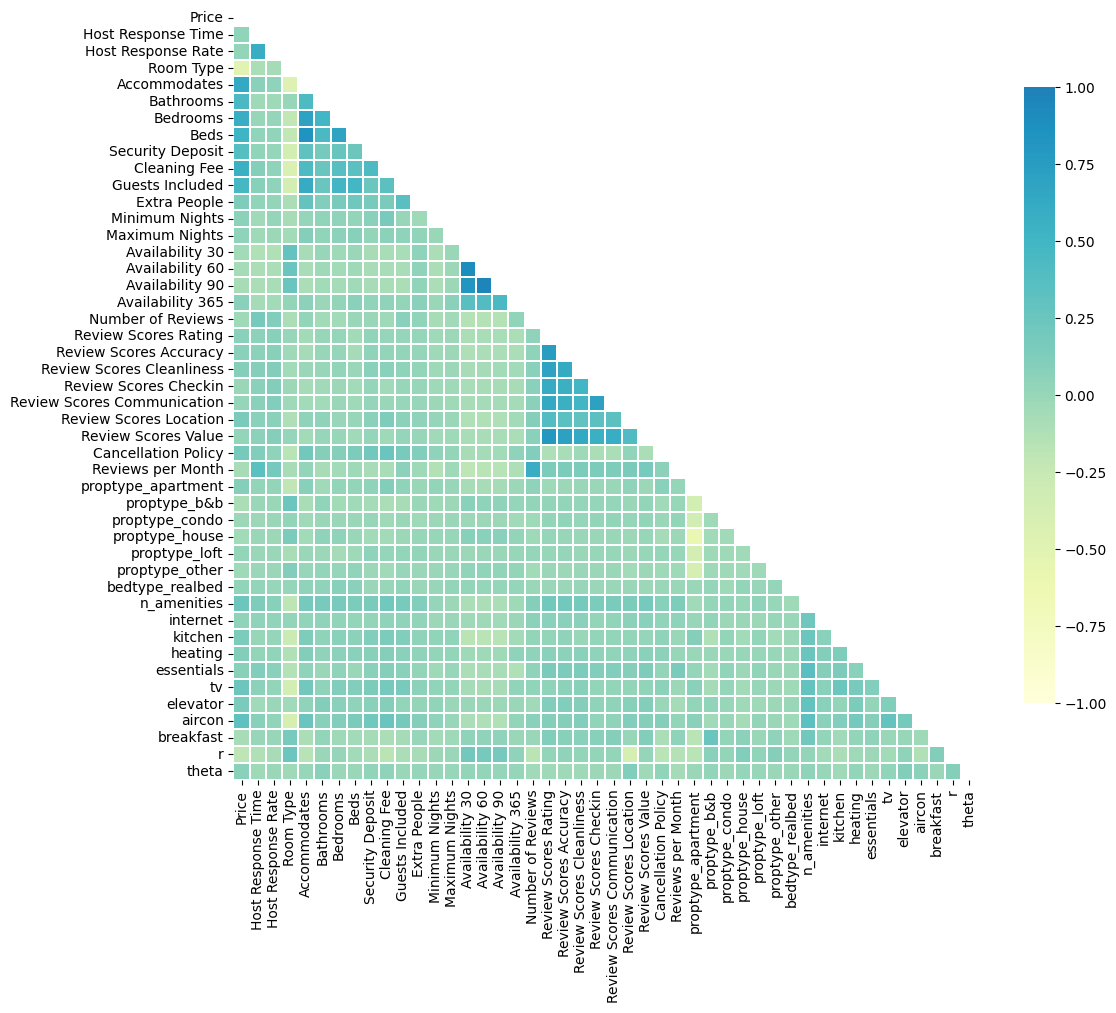

In [87]:
import seaborn as sns

corr = mad_train.corr()

# Upper triangle mask
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = -1.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### 1.7. Feature selection

In [88]:
# Drop availability, reviews and amenities columns
availability = ["Availability 30",
                "Availability 60",
                #"Availability 90",
                "Availability 365"
                ]

reviews = ["Review Scores Rating",
           "Review Scores Accuracy",
           #"Review Scores Cleanliness",
           "Review Scores Checkin",
           "Review Scores Communication",
           #"Review Scores Location",
           "Review Scores Value",
           "Reviews per Month",
           "Number of Reviews"
           ]

proptype = [#"proptype_apartment",
            "proptype_b&b",
            "proptype_condo",
            "proptype_house",
            "proptype_loft",
            "proptype_other"
            ]

amenities = ["internet",
             #"kitchen",
             #"heating",
             "essentials",
             #"tv",
             #"elevator",
             #"aircon",
             "breakfast"
             ]

drop_cols = ["Maximum Nights"] + availability + reviews + proptype + amenities
mad_train.drop(drop_cols, axis=1, inplace=True)
mad_test.drop(drop_cols, axis=1, inplace=True)

### 1.8. Pairplot

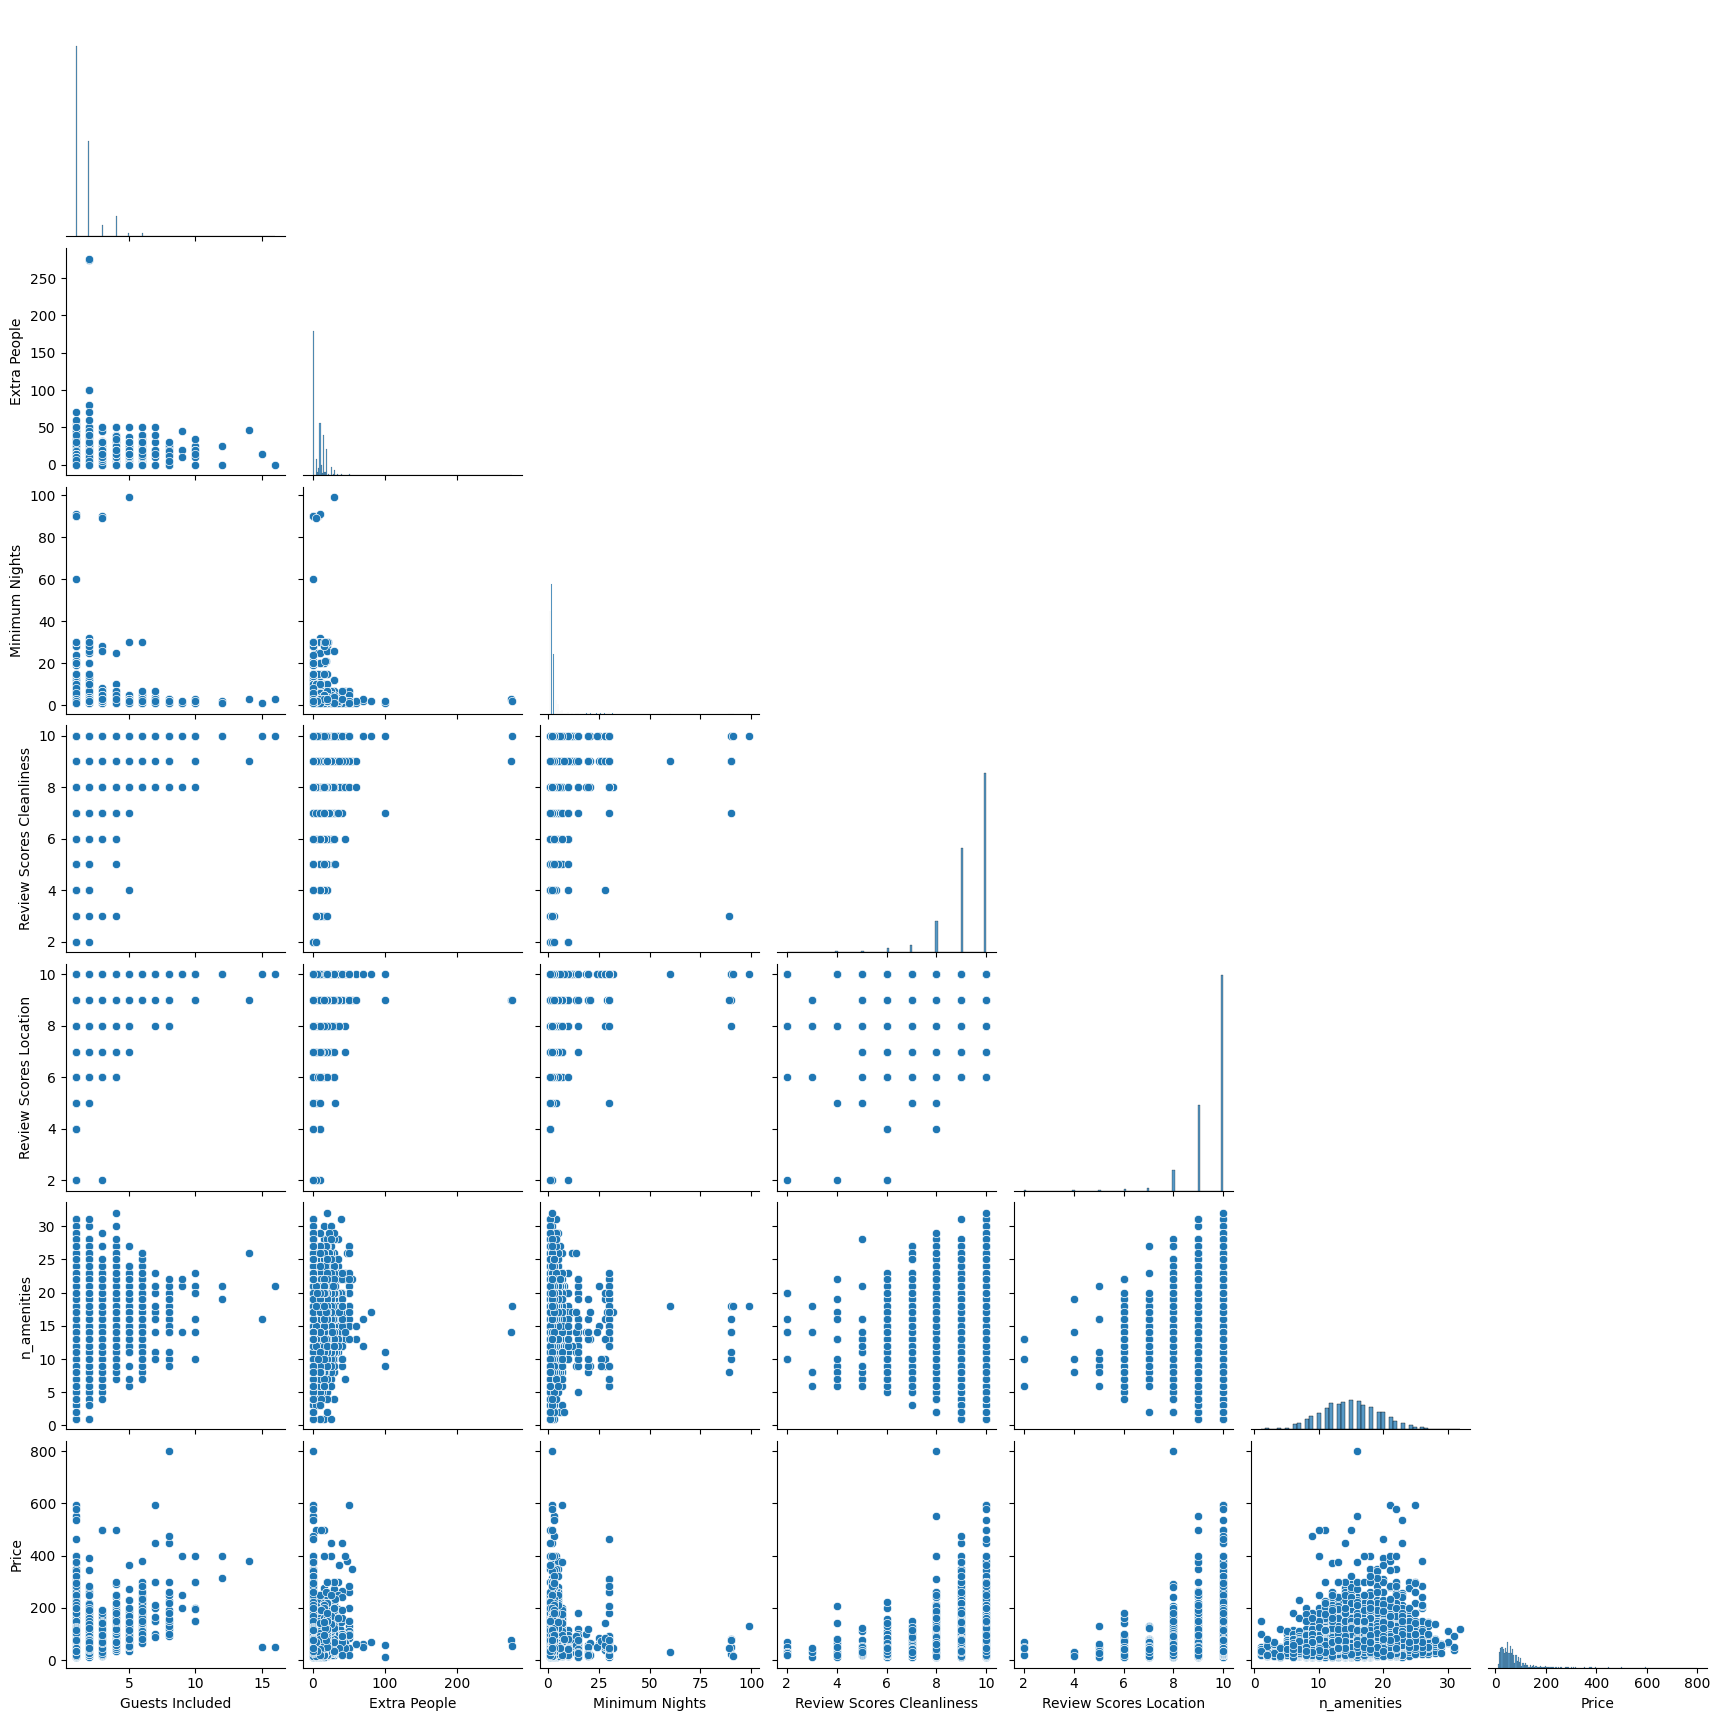

In [89]:
cols = [#"Accommodates",
        #"Bathrooms",
        #"Bedrooms",
        #"Beds",
        #"Security Deposit",
        #"Cleaning Fee",
        "Guests Included",
        "Extra People",
        "Minimum Nights",
        "Review Scores Cleanliness",
        "Review Scores Location",
        "n_amenities",
        "Price"]
sns.pairplot(mad_train[cols], corner=True)

### 1.9. Data transformations

In [90]:
mad_train["Price"] = np.log(mad_train["Price"])
mad_train["Review Scores Cleanliness"] = np.exp(mad_train["Review Scores Cleanliness"])
mad_train["Review Scores Location"] = np.exp(mad_train["Review Scores Location"])

mad_test["Price"] = np.log(mad_test["Price"])
mad_test["Review Scores Cleanliness"] = np.exp(mad_test["Review Scores Cleanliness"])
mad_test["Review Scores Location"] = np.exp(mad_test["Review Scores Location"])

new_names = {"Price":"log_price",
             "Review Scores Cleanliness": "exp_scores_cleanliness",
             "Review Scores Location": "exp_scores_location"
             }
mad_train.rename(columns=new_names, inplace=True)
mad_test.rename(columns=new_names, inplace=True)

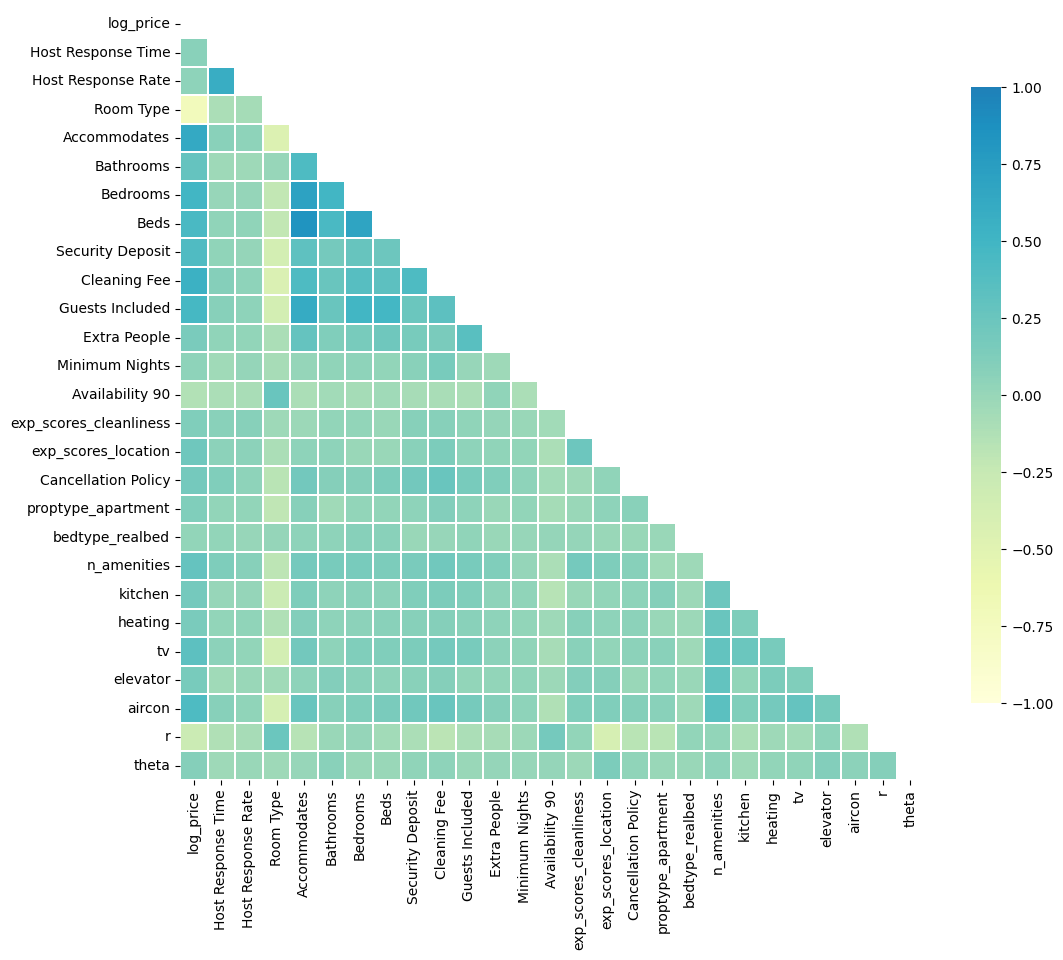

In [91]:
corr = mad_train.corr()

# Upper triangle mask
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = -1.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()



---



# 2. Modelling

In [92]:
from sklearn.preprocessing import StandardScaler

X_train = mad_train.drop("log_price", axis=1).values
y_train = mad_train["log_price"].values
X_test = mad_test.drop("log_price", axis=1).values
y_test = mad_test["log_price"].values

## 2.1. Ridge Regression

Best mean cross-validation score: -0.1025
Best parameters: {'alpha': 4.216965034285822}


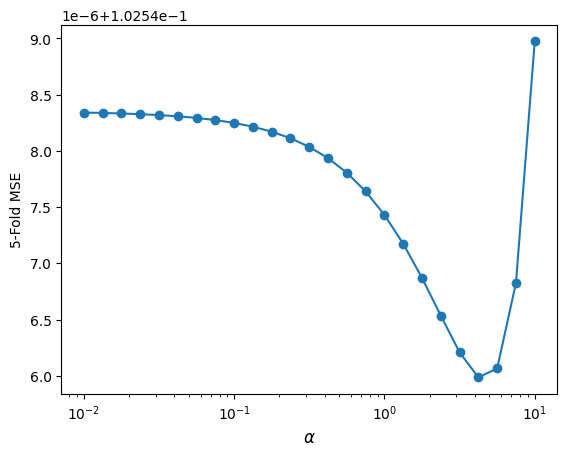

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alphas = np.logspace(-2, 1, 25)
grid = GridSearchCV(Ridge(random_state=0), scoring='neg_mean_squared_error', param_grid={'alpha': alphas}, cv=5)
grid.fit(X_train, y_train)

print(f"Best mean cross-validation score: {grid.best_score_:.4f}")
print(f"Best parameters: {grid.best_params_}")

scores = -1 * np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alphas, scores, '-o')
plt.xlabel(r'$\alpha$', fontsize=12)
plt.ylabel(f"{grid.cv}-Fold MSE")
plt.show()

In [97]:
alpha_optima = grid.best_params_['alpha']
ridge = Ridge(alpha=alpha_optima).fit(X_train, y_train)

# Prediction
y_test_pred_ridge = ridge.predict(X_test)
w = ridge.coef_
norm_w2 = w.dot(w)

# Error
error_test = np.mean(np.power(y_test - y_test_pred_ridge, 2))

for i, wi in enumerate(w):
    print(f"w{i + 1}: {wi:.4f}")

w1: -0.0279
w2: 0.0001
w3: -0.6103
w4: 0.0671
w5: 0.0960
w6: 0.1198
w7: -0.0304
w8: 0.0002
w9: 0.0037
w10: 0.0294
w11: -0.0028
w12: -0.0029
w13: 0.0017
w14: 0.0000
w15: 0.0000
w16: -0.0134
w17: -0.0459
w18: 0.0638
w19: 0.0023
w20: -0.0920
w21: 0.0028
w22: 0.0462
w23: 0.0853
w24: 0.1112
w25: -0.0000
w26: 0.0003


In [98]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred_ridge)
mse_test = mean_squared_error(y_test, y_test_pred_ridge)
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test: {mse_test:.4f}\n")

r2_train = r2_score(y_train, y_train_pred_ridge)
r2_test = r2_score(y_test, y_test_pred_ridge)
print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test: {r2_test:.4f}")

MSE Train: 0.1013
MSE Test: 0.0964

R2 Train: 0.7515
R2 Test: 0.7668


## 2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# grid search
max_depth = range(5, 15)
n_estimators = [100, 250, 500, 1000]
param_grid_rf = {"min_samples_leaf": [5],
                 "max_depth": max_depth,
                 "n_estimators": n_estimators,
                 "max_features": ["sqrt"]
                 }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

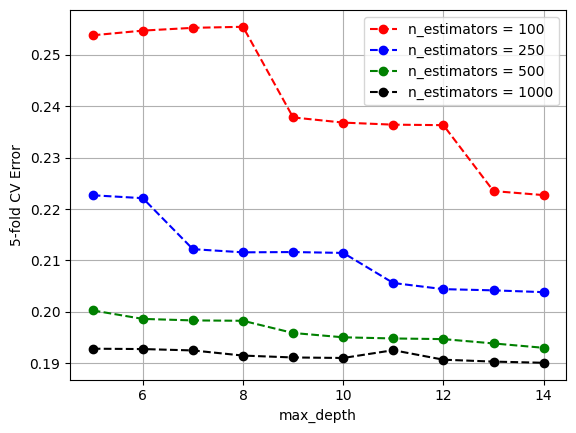

In [121]:
error = 1 - grid_rf.cv_results_["mean_test_score"].reshape(len(n_estimators), len(max_depth))
colors = ["r", "b", "g", "k", "m"]
for i, n in enumerate(n_estimators):
    plt.plot(max_depth, error[i,:], colors[i] + "--o", label="n_estimators = %g"%n)

plt.legend()
plt.xlabel(f"max_depth")
plt.ylabel(f"{grid_rf.cv}-fold CV Error")
plt.grid()
plt.show()

In [122]:
# Best parameters
best_params_rf = grid_rf.best_params_
best_score_rf = grid_rf.best_score_

print(f"Best parameters: {best_params_rf}")
print(f"Best mean cross-validation score: {best_score_rf:.4f}")

Best parameters: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 1000}
Best mean cross-validation score: 0.8099


In [123]:
rf = RandomForestRegressor(random_state=0,
                           min_samples_leaf=5,
                           max_depth=9,
                           n_estimators=1000,
                           max_features="sqrt").fit(X_train, y_train)

print(f"Train: {rf.score(X_train, y_train):.4f}")
print(f"Test: {rf.score(X_test, y_test):.4f}")

Train: 0.8376
Test: 0.8008


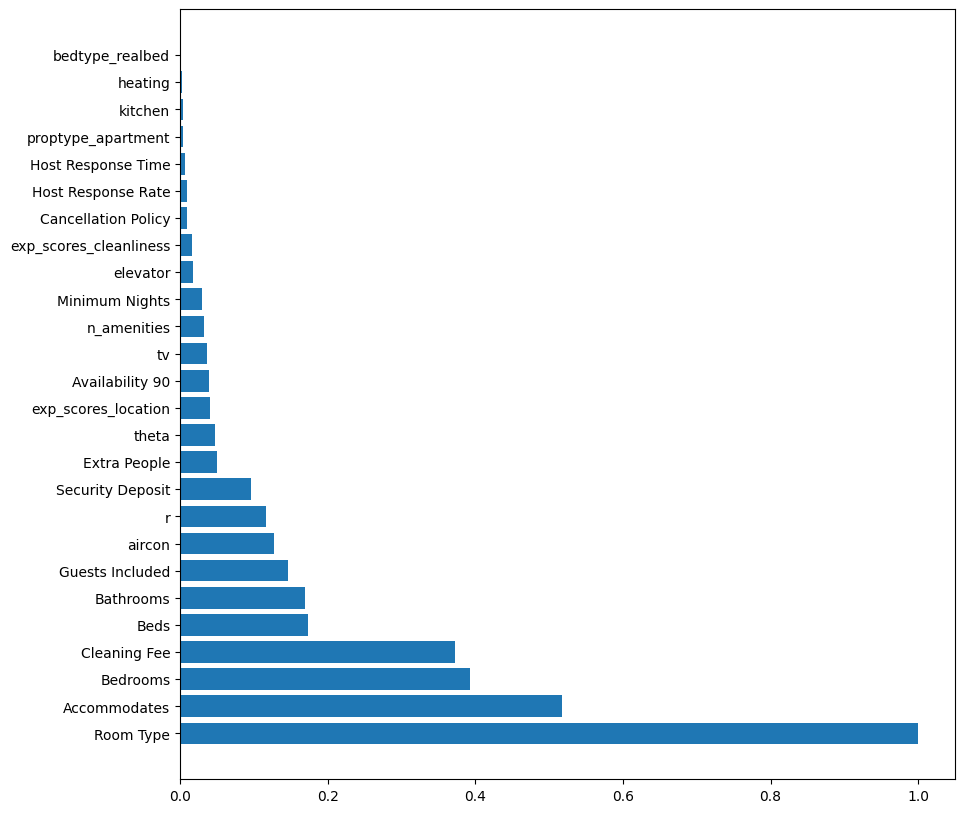

In [116]:
# Feature importance

feature_names = mad_train.columns[1:]

importances = rf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()

## 2.3. XGBoost

In [41]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBRegressor

# grid search
max_depth = [5, 10, 15]
n_estimators = [100, 200, 500, 1000]
learning_rate = [1e-3, 1e-2, 1e-1]
param_grid_xgb = {"max_depth": max_depth,
                  "n_estimators": n_estimators,
                  "learning_rate": learning_rate
                  }

grid_xgb = GridSearchCV(XGBRegressor(random_state=0), param_grid=param_grid_xgb, cv=5)
grid_xgb.fit(X_train, y_train)

In [105]:
# Best parameters
best_params_xgb = grid_xgb.best_params_
best_score_xgb = grid_xgb.best_score_

print(f"Best parameters: {best_params_xgb}")
print(f"Best mean cross-validation score: {best_score_xgb:.4f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best mean cross-validation score: 0.8378


In [106]:
max_depth_optima = grid_xgb.best_params_['max_depth']
xgb = XGBRegressor(random_state=0,
                   learning_rate=.1,
                   max_depth=4,
                   n_estimators=200).fit(X_train, y_train)

print(f"Train: {xgb.score(X_train, y_train):.4f}")
print(f"Test: {xgb.score(X_test, y_test):.4f}")

Train: 0.8865
Test: 0.8432


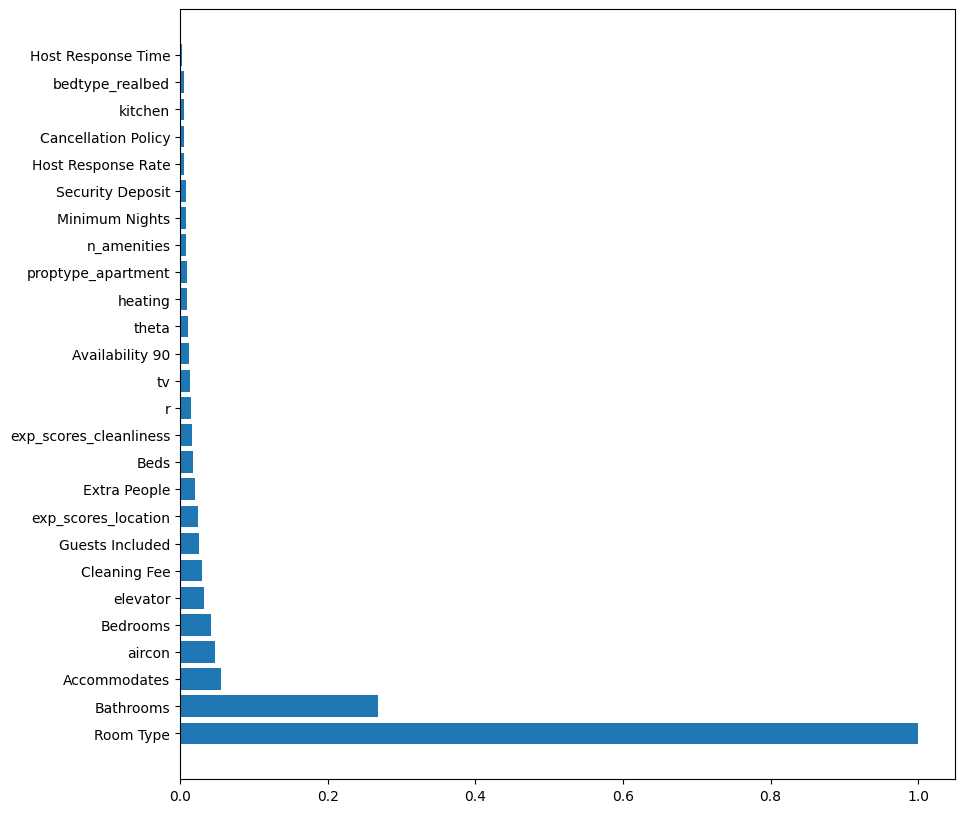

In [107]:
# Feature importance

importances = xgb.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.show()



---



# 3. Conclusiones

Ridge regression test score: 0.7668
Random Forest test score: 0.8008
XGBoost test score: 0.8432


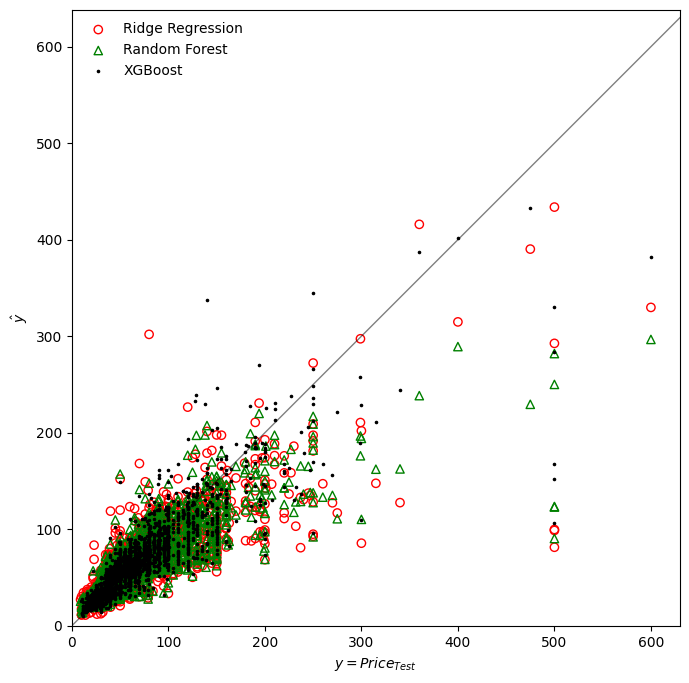

In [124]:
print(f"Ridge regression test score: {ridge.score(X_test, y_test):.4f}")
print(f"Random Forest test score: {rf.score(X_test, y_test):.4f}")
print(f"XGBoost test score: {xgb.score(X_test, y_test):.4f}")

y = np.exp(y_test)
y_hat_ridge = np.exp(ridge.predict(X_test))
y_hat_rf = np.exp(rf.predict(X_test))
y_hat_xgb = np.exp(xgb.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y, y_hat_ridge, label = 'Ridge Regression', marker="o",
           facecolors='none', edgecolors='r', linewidths=1)
ax.scatter(y, y_hat_rf, label = 'Random Forest', marker="^",
           facecolors='none', edgecolors="g", linewidths=1)
ax.scatter(y, y_hat_xgb, label = 'XGBoost', marker=".", c="k", s=10)
ax.axline((0, 0), slope=1, linewidth=1, color='k', alpha=.5)
ax.axis('square')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
plt.xlabel(r"$y = Price_{Test}$")
plt.ylabel(r"$\hat{y}$")
plt.legend(framealpha=0)

plt.show()

- Las prestaciones del modelo XGBoost son superiores tanto a las prestaciones del modelo Random Forest como a las obtenidas con la regresión lineal regularizada con Ridge.
- Se observa signos de posible overfitting en los resultados obtenidos con XGBoost y, también aunque en menor medida, en los resultados obtenidos con Random Forest.
- A pesar de que el modelo de regresión lineal regularizado con Ridge es el que peores prestaciones ofrece, la diferencia con los modelos basados en árboles no es tan significativa en comparación con el tiempo de entrenamiento que requieren los modelos basados en árboles.